In [1]:
import geopandas as gpd
import pyogrio
from shapely.geometry import Point
import numpy as np
from datetime import timedelta
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from collections import deque
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation


In [2]:
#Reading the Data File

file_path = 'clustered_data_4months.geojson'
data = gpd.read_file(file_path)


data.head(), data.columns

print(data)
print(data.columns)
print(len(data))
print(len(data[data['cnprcp_mean']>0]))


                           time satellite instrument    swath_width  \
0     2024-05-22 00:00:00+00:00      Test       Test  278640.704057   
1     2024-05-22 00:02:00+00:00      Test       Test  277041.710508   
2     2024-05-22 00:04:00+00:00      Test       Test  275419.732317   
3     2024-05-22 00:06:00+00:00      Test       Test  273866.283658   
4     2024-05-22 00:08:00+00:00      Test       Test  272466.738302   
...                         ...       ...        ...            ...   
94475 2024-09-22 00:22:00+00:00      Test       Test  269537.568606   
94476 2024-09-22 00:24:00+00:00      Test       Test  267843.485083   
94477 2024-09-22 00:26:00+00:00      Test       Test  266231.255770   
94478 2024-09-22 00:28:00+00:00      Test       Test  264783.666193   
94479 2024-09-22 00:30:00+00:00      Test       Test  263569.285624   

       valid_obs  solar_hour time_range  month    lat_sat     lon_sat  \
0           True    9.006320    morning      5 -38.142798  134.265144   
1

In [3]:
world = gpd.read_file('110m_cultural.zip', layer = 'ne_110m_admin_0_boundary_lines_land')
geometry = [Point(xy) for xy in zip(data['lon_sat'], data['lat_sat'])]
geo_full = gpd.GeoDataFrame(data, geometry=geometry)
geo_full['ground_track'] = geo_full.apply(lambda row: 0 if world.contains(row.geometry).any() else 1, axis=1)
data['ground_track'] = geo_full['ground_track']

time_range = []
for i in data['time_range']: 
    if i=='e_morning':
        time_range.append(0) 
    if i=='morning':
        time_range.append(1)
    if i=='afternoon':
        time_range.append(2)
    if i=='evening':
        time_range.append(3)
    if i=='night':
        time_range.append(4)
data['time_range_encoded'] = time_range.copy()


In [4]:
#For RandomForest model
features = data[['lat_sat', 'lon_sat', 'solar_hour', 'ground_track', 'time_range_encoded']]
target = (data['cnprcp_mean'] > 0).astype(int)

In [14]:
tscv = TimeSeriesSplit(n_splits=5)
#setting timeseries split for cross-validation (5-fold)

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, n_jobs=-1, criterion='entropy')
#Setting up RandomForest Model


#n_estimators could be calculated for better result.
#Track reward values obtained from the RF model.

In [7]:
class Simulator:
    def __init__(self, state_database):
        self.state_database = state_database.reset_index(drop=True)
        self._index = None
        self._time_of_last_action = None
        self.n_steps = len(state_database)

    def reset(self):
        self._index = 0
        self._time_of_last_action = self.state_database.iloc[self._index]["time"]
        return self.get_state()

    def step(self, action):
        state = self.get_state()
        reward = self.get_reward(state, action)
        done = self._index >= self.n_steps - 1
        self.tick(1)
        next_state = self.get_state() if not done else None
        return next_state, reward, done

    def tick(self, index_step):
        self._index += index_step

    def get_state(self):
        return {
            "lat_sat": self.state_database.iloc[self._index]["lat_sat"],
            "lon_sat": self.state_database.iloc[self._index]["lon_sat"],
            "solar_hour": self.state_database.iloc[self._index]["solar_hour"],
            "elapsed_time": (self.state_database.iloc[self._index]["time"] - self._time_of_last_action).total_seconds(),
            "ground_track": self.state_database.iloc[self._index]["ground_track"]
        }

    def get_reward(self, state, action):
        cnprcp_mean = self.state_database.iloc[self._index]["cnprcp_mean"]
        if action == 1 and cnprcp_mean > 0:
            self._time_of_last_action = self.state_database.iloc[self._index]["time"]
            return 1
        elif action == 1 and cnprcp_mean == 0:
            self._time_of_last_action = self.state_database.iloc[self._index]["time"]
            return -1
        elif action == 0 and cnprcp_mean > 0:
            return -0.5
        else:
            return 0

    def get_actual(self):
        if self.index >= len(self.data):
            return None
        return int(self.state_database.iloc[self._index]["cnprcp_mean"] > 0)

In [15]:
all_test_results =[]

for train_idx, test_idx in tscv.split(features):
    train_features, test_features = features.iloc[train_idx], features.iloc[test_idx]
    train_target, test_target = target.iloc[train_idx], target.iloc[test_idx]

    # Train and Evaluate RF Classifier
    rf_classifier.fit(train_features, train_target)
    rf_predictions = rf_classifier.predict(test_features)
    rf_precision = precision_score(test_target, rf_predictions, zero_division=0)
    rf_recall = recall_score(test_target, rf_predictions, zero_division=0)
    print(f"RandomForest - Precision: {rf_precision:.2f}")
    print(f"RandomForest - Recall: {rf_recall:.2f}")  

    tmp_df = test_features.copy()
    tmp_df['actual'] = test_target.values
    tmp_df['predicted'] = rf_predictions

    all_test_results.append(tmp_df)

RandomForest - Precision: 0.25
RandomForest - Recall: 0.08
RandomForest - Precision: 0.19
RandomForest - Recall: 0.07
RandomForest - Precision: 0.29
RandomForest - Recall: 0.08
RandomForest - Precision: 0.30
RandomForest - Recall: 0.10
RandomForest - Precision: 0.16
RandomForest - Recall: 0.11


In [9]:
results_df = pd.concat(all_test_results).reset_index(drop=True)

print(results_df)

         lat_sat     lon_sat  solar_hour  ground_track  time_range_encoded  \
0      41.561310   82.193134    9.978955             1                   1   
1      45.614797   90.953148   10.596308             1                   1   
2      45.614797   90.953148   10.596308             1                   1   
3      48.809108  100.980472   11.298148             1                   1   
4      50.927527  112.172598   12.077643             1                   2   
...          ...         ...         ...           ...                 ...   
85885 -30.398509  116.457490    8.252109             1                   1   
85886 -24.776929  122.144472    8.664586             1                   1   
85887 -18.915463  127.290042    9.040970             1                   1   
85888 -12.887910  132.052517    9.391817             1                   1   
85889  -6.754432  136.569036    9.726269             1                   1   

       actual  predicted  
0           0          0  
1        

In [10]:
def modelResult(actual, predicted):
    if actual == 1 and predicted == 1:
        return "TP"
    elif actual == 0 and predicted == 1:
        return "FP"
    elif actual == 0 and predicted == 0:
        return "TN"
    else: 
        return "FN"

results_df["confusion"] = results_df.apply(
    lambda row: modelResult(row["actual"], row["predicted"]), axis=1
)

geometry = [Point(xy) for xy in zip(results_df["lon_sat"], results_df["lat_sat"])]
df = gpd.GeoDataFrame(results_df, geometry=geometry)
df.crs = "EPSG:4326"

display(df)

,lat_sat,lon_sat,solar_hour,ground_track,time_range_encoded,actual,predicted,confusion,geometry
0,41.561310,82.193134,9.978955,1,1,0,0,TN,POINT (82.19313 41.56131)
1,45.614797,90.953148,10.596308,1,1,0,0,TN,POINT (90.95315 45.6148)
2,45.614797,90.953148,10.596308,1,1,0,0,TN,POINT (90.95315 45.6148)
3,48.809108,100.980472,11.298148,1,1,0,0,TN,POINT (100.98047 48.80911)
4,50.927527,112.172598,12.077643,1,2,0,0,TN,POINT (112.1726 50.92753)
...,...,...,...,...,...,...,...,...,...
85885,-30.398509,116.457490,8.252109,1,1,0,0,TN,POINT (116.45749 -30.39851)
85886,-24.776929,122.144472,8.664586,1,1,0,0,TN,POINT (122.14447 -24.77693)
85887,-18.915463,127.290042,9.040970,1,1,0,0,TN,POINT (127.29004 -18.91546)
85888,-12.887910,132.052517,9.391817,1,1,0,0,TN,POINT (132.05252 -12.88791)


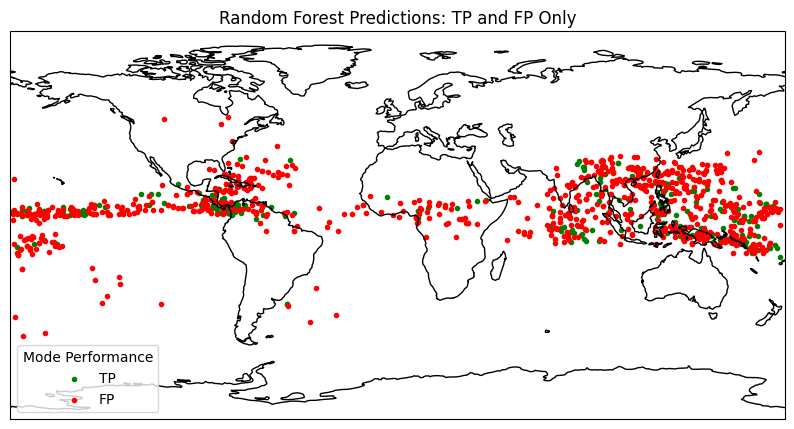

In [11]:
color_map = {
    "TP": "green",
    "FP": "red",
}

fig, ax = plt.subplots(figsize=(10, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()


for label, color in color_map.items():
    subset = df[df["confusion"] == label]
    subset.plot(
        ax=ax,
        marker='.',
        color=color,
        label=label,
        transform=ccrs.PlateCarree()
    )

plt.legend(title="Mode Performance", loc="lower left")
plt.title("Random Forest Predictions: TP and FP Only")
plt.show()

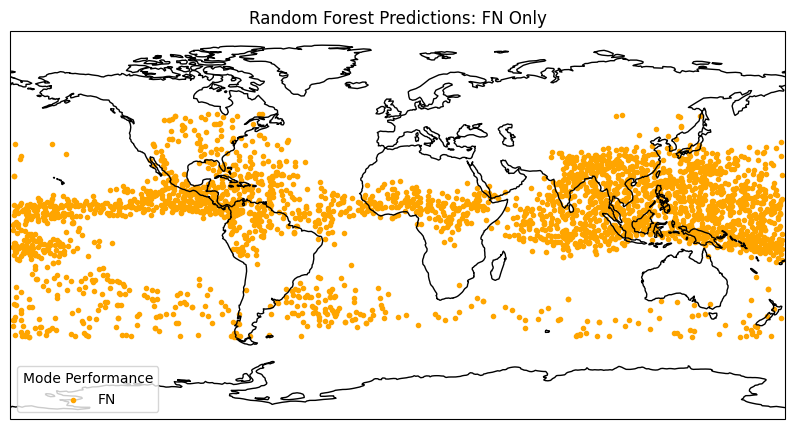

In [12]:
fig, ax = plt.subplots(figsize=(10, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()



subset = df[df["confusion"] == 'FN']
subset.plot(
    ax=ax,
    marker='.',
    color='orange',
    label='FN',
    transform=ccrs.PlateCarree()
    )

plt.legend(title="Mode Performance", loc="lower left")
plt.title("Random Forest Predictions: FN Only")
plt.show()